In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
from UnarySim.sw.kernel.linear import UnaryLinear
from UnarySim.sw.stream.gen import RNG, SourceGen, BSGen
from UnarySim.sw.metric.metric import ProgressiveError
import matplotlib.pyplot as plt
import time

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [17]:
def linear_test(rng="Sobol", in_feature=128, out_feature=10000, bitwidth=8, bias=True):
    modes = ["bipolar", "unipolar"]
    stype = torch.float
    btype = torch.float
    rtype = torch.float
    scaled = [True, False]
    result_pe = []
    
    for mode in modes:
        for scale in scaled:
            length = 2**bitwidth
            result_pe_cycle = []
            fc = torch.nn.Linear(in_feature, out_feature, bias=bias).to(device) ## binary
            
            if mode is "unipolar":
                fc.weight.data = torch.rand(out_feature, in_feature).mul(length).round().div(length).to(device) ## not change
                if bias is True:
                    fc.bias.data = torch.rand(1, out_feature).mul(length).round().div(length).to(device) ## c
            elif mode is "bipolar":
                fc.weight.data = torch.rand(out_feature, in_feature).mul(2).sub(1).mul(length).round().div(length).to(device)
                if bias is True:
                    fc.bias.data = torch.rand(1, out_feature).mul(2).sub(1).mul(length).round().div(length).to(device)

            ufc = UnaryLinear(in_feature, out_feature, fc.weight, fc.bias, 
                              bitwidth=bitwidth, ## internel rng
                              mode=mode, scaled=scale, bias=bias, 
                              stype=stype, btype=btype, rtype=rtype).to(device) ## weight bias in nvvm

            iVec = ((torch.rand(1, in_feature)*length).round()/length).to(device) ## 1 batch size, parellel
            oVec = fc(iVec)

            iVecSource = SourceGen(iVec, bitwidth=bitwidth, mode=mode, rtype=rtype)().to(device)
            iVecRNG = RNG(bitwidth, 1, rng, rtype=rtype)().to(device)
            iVecBS = BSGen(iVecSource, iVecRNG, stype=stype).to(device)

            iVecPE = ProgressiveError(iVec, mode=mode).to(device)
            
            if scale is True:
                if bias == 0:
                    oVecPE = ProgressiveError(oVec, scale=in_feature, mode=mode).to(device)
                elif bias ==1:
                    oVecPE = ProgressiveError(oVec, scale=in_feature+1, mode=mode).to(device)
            else:
                oVecPE = ProgressiveError(oVec, scale=1, mode=mode).to(device)
            
            with torch.no_grad():
                idx = torch.zeros(iVecSource.size()).type(torch.long).to(device)
                start_time = time.time()
                for i in range(length):
                    iBS = iVecBS(idx + i)
                    iVecPE.Monitor(iBS)

                    oVecU = ufc(iBS)
                    oVecPE.Monitor(oVecU)
                    if bias is False:
                        result_pe_cycle.append(1-torch.sqrt(torch.sum(torch.mul(oVecPE()[1], oVecPE()[1]))/out_feature).item())
                    else:
                        result_pe_cycle.append(1-torch.sqrt(torch.sum(torch.mul(oVecPE()[1], oVecPE()[1]))/(out_feature+1)).item())
                print("--- %s seconds ---" % (time.time() - start_time))
                print("input error: ", "min:", torch.min(iVecPE()[1]).item(), "max:", torch.max(iVecPE()[1]).item())
                print("output error: ", "min:", torch.min(oVecPE()[1]).item(), "max:", torch.max(oVecPE()[1]).item(), "RMSE: ", torch.sqrt(torch.sum(torch.mul(oVecPE()[1], oVecPE()[1]))/out_feature).item())
                result_pe = oVecPE()[1][0].cpu().numpy()
                print("error distribution=========>")
                plt.figure(figsize=(3,1.5))
                fig = plt.hist(result_pe, bins='auto')  # arguments are passed to np.histogram
                plt.title("data: "+mode+", scaled: "+str(scale))
                plt.show()
                print("progressive accuracy=========>")
                plt.figure(figsize=(3,1.5))
                fig = plt.plot(result_pe_cycle)  # arguments are passed to np.histogram
                plt.title("data: "+mode+", scaled: "+str(scale))
                plt.show()
                

--- 0.8197441101074219 seconds ---
input error:  min: -0.00390625 max: 0.00390625
output error:  min: -0.010627197101712227 max: -0.0017481576651334763 RMSE:  0.006577998865395784
error distribution=========>


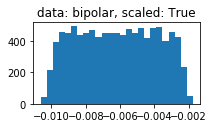

progressive accuracy=========>


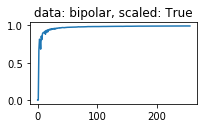

--- 0.7831182479858398 seconds ---
input error:  min: -0.00390625 max: 0.00390625
output error:  min: -1.2265625 max: 0.1171875 RMSE:  0.3043721318244934
error distribution=========>


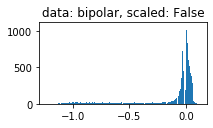

progressive accuracy=========>


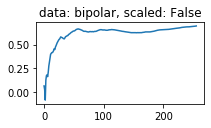

--- 0.6115562915802002 seconds ---
input error:  min: -0.00390625 max: 0.0
output error:  min: -0.005633413791656494 max: -0.0013278722763061523 RMSE:  0.0036307822447270155
error distribution=========>


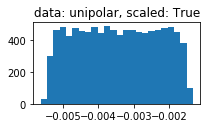

progressive accuracy=========>


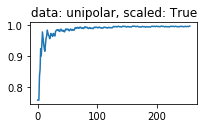

--- 0.4183802604675293 seconds ---
input error:  min: -0.00390625 max: 0.0
output error:  min: 0.0 max: 0.0 RMSE:  0.0
error distribution=========>


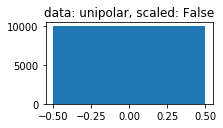

progressive accuracy=========>


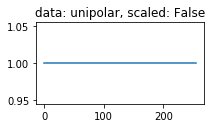

In [18]:
rng = "Sobol"
in_feature = 512
out_feature = 10000
bitwidth = 8
bias = True
linear_test(rng, in_feature, out_feature, bitwidth, bias)

--- 1.2359988689422607 seconds ---
input error:  min: -0.00390625 max: 0.00390625
output error:  min: -0.010603846982121468 max: -0.0014385497197508812 RMSE:  0.006481355521827936
error distribution=========>


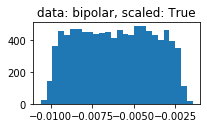

progressive accuracy=========>


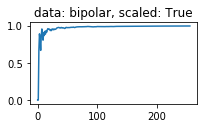

--- 1.2839984893798828 seconds ---
input error:  min: -0.00390625 max: 0.00390625
output error:  min: -1.47576904296875 max: 0.53125 RMSE:  0.3420049548149109
error distribution=========>


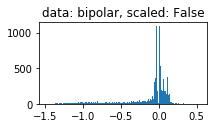

progressive accuracy=========>


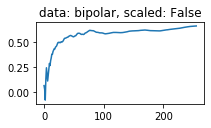

--- 0.7230007648468018 seconds ---
input error:  min: -0.00390625 max: 0.0
output error:  min: -0.006243795156478882 max: -0.0018169879913330078 RMSE:  0.004150678403675556
error distribution=========>


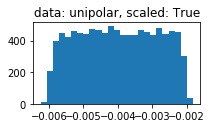

progressive accuracy=========>


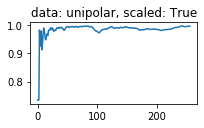

--- 0.5370111465454102 seconds ---
input error:  min: -0.00390625 max: 0.0
output error:  min: -0.0078125 max: 0.0 RMSE:  7.812499825377017e-05
error distribution=========>


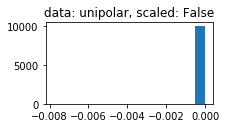

progressive accuracy=========>


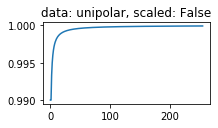

In [6]:
rng = "LFSR"
in_feature = 512
out_feature = 10000
bitwidth = 8
bias = True
linear_test(rng, in_feature, out_feature, bitwidth, bias)

--- 0.7329978942871094 seconds ---
input error:  min: -0.00390625 max: 0.00390625
output error:  min: -0.010330229997634888 max: -0.0011387579143047333 RMSE:  0.006162330042570829
error distribution=========>


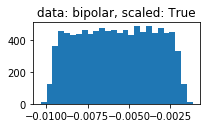

progressive accuracy=========>


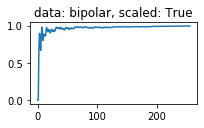

--- 0.7249979972839355 seconds ---
input error:  min: -0.00390625 max: 0.00390625
output error:  min: -1.8671875 max: 1.640625 RMSE:  0.5455414652824402
error distribution=========>


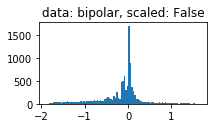

progressive accuracy=========>


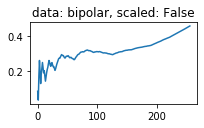

--- 0.5229997634887695 seconds ---
input error:  min: 0.0 max: 0.0
output error:  min: -0.0055594295263290405 max: -0.0012360811233520508 RMSE:  0.0035902531817555428
error distribution=========>


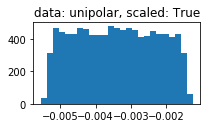

progressive accuracy=========>


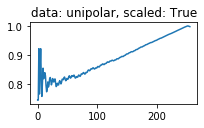

--- 0.5239994525909424 seconds ---
input error:  min: 0.0 max: 0.0
output error:  min: 0.0 max: 0.0 RMSE:  0.0
error distribution=========>


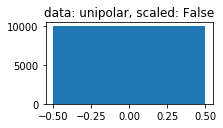

progressive accuracy=========>


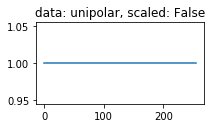

In [7]:
rng = "Race"
in_feature = 512
out_feature = 10000
bitwidth = 8
bias = True
linear_test(rng, in_feature, out_feature, bitwidth, bias)

--- 0.8400099277496338 seconds ---
input error:  min: -0.00390625 max: 0.00390625
output error:  min: -0.010584097355604172 max: -0.0016429818933829665 RMSE:  0.006561028305441141
error distribution=========>


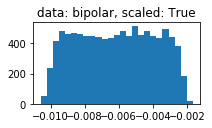

progressive accuracy=========>


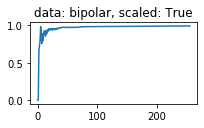

--- 0.8350114822387695 seconds ---
input error:  min: -0.00390625 max: 0.00390625
output error:  min: -1.269805908203125 max: 0.3046875 RMSE:  0.30728864669799805
error distribution=========>


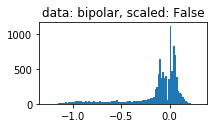

progressive accuracy=========>


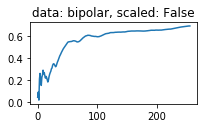

--- 0.5340096950531006 seconds ---
input error:  min: 0.0 max: 0.0
output error:  min: -0.005617201328277588 max: -0.0012702345848083496 RMSE:  0.003623849945142865
error distribution=========>


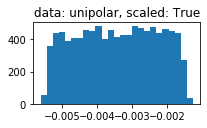

progressive accuracy=========>


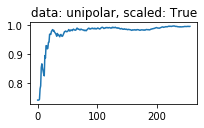

--- 0.5440099239349365 seconds ---
input error:  min: 0.0 max: 0.0
output error:  min: 0.0 max: 0.0 RMSE:  0.0
error distribution=========>


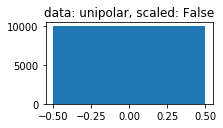

progressive accuracy=========>


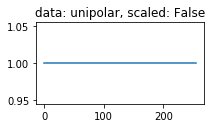

In [8]:
rng = "SYS"
in_feature = 512
out_feature = 10000
bitwidth = 8
bias = True
linear_test(rng, in_feature, out_feature, bitwidth, bias)

In [19]:
def linear_intermittent_test(rng="Sobol", in_feature=32, out_feature=32, bitwidth=8, bias=True, power_off=128):
    modes = ["unipolar"]
    stype = torch.float
    btype = torch.float
    rtype = torch.float
    scaled = [True]
    result_pe = []
    check_point = []
    device = "cpu"
    
    for mode in modes:
        for scale in scaled:
            length = 2**bitwidth
            result_pe_cycle = []
            fc = torch.nn.Linear(in_feature, out_feature, bias=bias).to(device) ## binary
            
            if mode is "unipolar":
                fc.weight.data = torch.rand(out_feature, in_feature).mul(length).round().div(length).to(device) ## not change
                if bias is True:
                    fc.bias.data = torch.rand(1, out_feature).mul(length).round().div(length).to(device) ## c
            elif mode is "bipolar":
                fc.weight.data = torch.rand(out_feature, in_feature).mul(2).sub(1).mul(length).round().div(length).to(device)
                if bias is True:
                    fc.bias.data = torch.rand(1, out_feature).mul(2).sub(1).mul(length).round().div(length).to(device)

            ufc = UnaryLinear(in_feature, out_feature, fc.weight, fc.bias, 
                              bitwidth=bitwidth, ## internel rng
                              mode=mode, scaled=scale, bias=bias, 
                              stype=stype, btype=btype, rtype=rtype).to(device) ## weight bias in nvvm

            iVec = ((torch.rand(1, in_feature)*length).round()/length).to(device) ## 1 batch size, parellel
            oVec = fc(iVec)

            iVecSource = SourceGen(iVec, bitwidth=bitwidth, mode=mode, rtype=rtype)().to(device)
            iVecRNG = RNG(bitwidth, 1, rng, rtype=rtype)().to(device)
            iVecBS = BSGen(iVecSource, iVecRNG, stype=stype).to(device)

            iVecPE = ProgressiveError(iVec, mode=mode).to(device)
            
            if scale is True:
                if bias == 0:
                    oVecPE = ProgressiveError(oVec, scale=in_feature, mode=mode).to(device)
                elif bias ==1:
                    oVecPE = ProgressiveError(oVec, scale=in_feature+1, mode=mode).to(device)
            else:
                oVecPE = ProgressiveError(oVec, scale=1, mode=mode).to(device)
            
            with torch.no_grad():
                idx = torch.zeros(iVecSource.size()).type(torch.long).to(device)
                start_time = time.time()
                for i in range(length):
                    iBS = iVecBS(idx + i)
                    iVecPE.Monitor(iBS)

                    oVecU = ufc(iBS)
                    oVecPE.Monitor(oVecU)
                    if bias is False:
                        result_pe_cycle.append(1-torch.sqrt(torch.sum(torch.mul(oVecPE()[1], oVecPE()[1]))/out_feature).item())
                    else:
                        result_pe_cycle.append(1-torch.sqrt(torch.sum(torch.mul(oVecPE()[1], oVecPE()[1]))/(out_feature+1)).item())
                print("--- %s seconds ---" % (time.time() - start_time))
                print("input error: ", "min:", torch.min(iVecPE()[1]).item(), "max:", torch.max(iVecPE()[1]).item())
                print("output error: ", "min:", torch.min(oVecPE()[1]).item(), "max:", torch.max(oVecPE()[1]).item(), "RMSE: ", torch.sqrt(torch.sum(torch.mul(oVecPE()[1], oVecPE()[1]))/out_feature).item())
                result_pe = oVecPE()[1][0].cpu().numpy()
                print("error distribution=========>")
                plt.figure(figsize=(3,1.5))
                fig = plt.hist(result_pe, bins='auto')  # arguments are passed to np.histogram
                plt.title("data: "+mode+", scaled: "+str(scale))
                plt.show()
                print("progressive accuracy=========>")
                plt.figure(figsize=(3,1.5))
                fig = plt.plot(result_pe_cycle)  # arguments are passed to np.histogram
                plt.title("data: "+mode+", scaled: "+str(scale))
                plt.show()

--- 0.06405758857727051 seconds ---
input error:  min: 0.0 max: 0.0
output error:  min: -0.005238384008407593 max: -0.0014449656009674072 RMSE:  0.003752886550500989
error distribution=========>


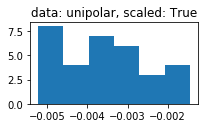

progressive accuracy=========>


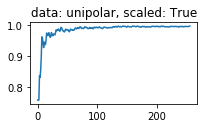

In [20]:
linear_intermittent_test(rng="Sobol", in_feature=32, out_feature=32, bitwidth=8, bias=True, power_off=128)

In [8]:
def linear_intermittent_perfect_test(rng="Sobol", in_feature=32, out_feature=32, bitwidth=8, bias=True, power_off=128):
    modes = ["unipolar"]
    stype = torch.float
    btype = torch.float
    rtype = torch.float
    scaled = [True]
    result_pe = []
    check_point = []
    device = "cpu"
    
    for mode in modes:
        for scale in scaled:
            length = 2**bitwidth
            result_pe_cycle = []
            fc = torch.nn.Linear(in_feature, out_feature, bias=bias).to(device) ## binary
            
            if mode is "unipolar":
                fc.weight.data = torch.rand(out_feature, in_feature).mul(length).round().div(length).to(device) ## not change
                if bias is True:
                    fc.bias.data = torch.rand(1, out_feature).mul(length).round().div(length).to(device) ## c
            elif mode is "bipolar":
                fc.weight.data = torch.rand(out_feature, in_feature).mul(2).sub(1).mul(length).round().div(length).to(device)
                if bias is True:
                    fc.bias.data = torch.rand(1, out_feature).mul(2).sub(1).mul(length).round().div(length).to(device)

            ufc = UnaryLinear(in_feature, out_feature, fc.weight, fc.bias, 
                              bitwidth=bitwidth, ## internel rng
                              mode=mode, scaled=scale, bias=bias, 
                              stype=stype, btype=btype, rtype=rtype).to(device) ## weight bias in nvvm

            iVec = ((torch.rand(1, in_feature)*length).round()/length).to(device) ## 1 batch size, parellel
            oVec = fc(iVec)

            iVecSource = SourceGen(iVec, bitwidth=bitwidth, mode=mode, rtype=rtype)().to(device)
            iVecRNG = RNG(bitwidth, 1, rng, rtype=rtype)().to(device)
            iVecBS = BSGen(iVecSource, iVecRNG, stype=stype).to(device)

            iVecPE = ProgressiveError(iVec, mode=mode).to(device)
            
            if scale is True:
                if bias == 0:
                    oVecPE = ProgressiveError(oVec, scale=in_feature, mode=mode).to(device)
                elif bias ==1:
                    oVecPE = ProgressiveError(oVec, scale=in_feature+1, mode=mode).to(device)
            else:
                oVecPE = ProgressiveError(oVec, scale=1, mode=mode).to(device)
            
            with torch.no_grad():
                idx = torch.zeros(iVecSource.size()).type(torch.long).to(device)
                start_time = time.time()
                for i in range(0,power_off):
                    iBS = iVecBS(idx + i)
                    iVecPE.Monitor(iBS)
                    
                    oVecU = ufc(iBS)
                    oVecPE.Monitor(oVecU)
                    if bias is False:
                        result_pe_cycle.append(1-torch.sqrt(torch.sum(torch.mul(oVecPE()[1], oVecPE()[1]))/out_feature).item())
                    else:
                        result_pe_cycle.append(1-torch.sqrt(torch.sum(torch.mul(oVecPE()[1], oVecPE()[1]))/(out_feature+1)).item())
                
                for i in range(power_off,length):
                    
                    iBS = iVecBS(idx + i)
                    iVecPE.Monitor(iBS)

                    oVecU = ufc(iBS)
                    oVecPE.Monitor(oVecU)
                    if bias is False:
                        result_pe_cycle.append(1-torch.sqrt(torch.sum(torch.mul(oVecPE()[1], oVecPE()[1]))/out_feature).item())
                    else:
                        result_pe_cycle.append(1-torch.sqrt(torch.sum(torch.mul(oVecPE()[1], oVecPE()[1]))/(out_feature+1)).item())
                print("--- %s seconds ---" % (time.time() - start_time))
                print("input error: ", "min:", torch.min(iVecPE()[1]).item(), "max:", torch.max(iVecPE()[1]).item())
                print("output error: ", "min:", torch.min(oVecPE()[1]).item(), "max:", torch.max(oVecPE()[1]).item(), "RMSE: ", torch.sqrt(torch.sum(torch.mul(oVecPE()[1], oVecPE()[1]))/out_feature).item())
                result_pe = oVecPE()[1][0].cpu().numpy()
                print("error distribution=========>")
                plt.figure(figsize=(3,1.5))
                fig = plt.hist(result_pe, bins='auto')  # arguments are passed to np.histogram
                plt.title("data: "+mode+", scaled: "+str(scale))
                plt.show()
                print("progressive accuracy=========>")
                plt.figure(figsize=(3,1.5))
                fig = plt.plot(result_pe_cycle)  # arguments are passed to np.histogram
                plt.title("data: "+mode+", scaled: "+str(scale))
                plt.show()

--- 0.06405830383300781 seconds ---
input error:  min: 0.0 max: 0.0
output error:  min: -0.004692763090133667 max: -0.0013247430324554443 RMSE:  0.003430429846048355
error distribution=========>


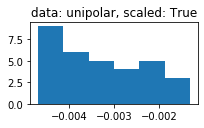

progressive accuracy=========>


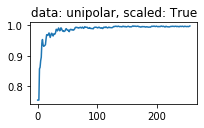

In [9]:
linear_intermittent_perfect_test(rng="Sobol", in_feature=32, out_feature=32, bitwidth=8, bias=True, power_off=128)

In [10]:
def linear_intermittent_perfect_test(rng="Sobol", in_feature=32, out_feature=32, bitwidth=8, bias=True, power_off=128):
    modes = ["unipolar"]
    stype = torch.float
    btype = torch.float
    rtype = torch.float
    scaled = [True]
    result_pe = []
    check_point = []
    device = "cpu"
    
    for mode in modes:
        for scale in scaled:
            length = 2**bitwidth
            result_pe_cycle = []
            fc = torch.nn.Linear(in_feature, out_feature, bias=bias).to(device) ## binary
            
            if mode is "unipolar":
                fc.weight.data = torch.rand(out_feature, in_feature).mul(length).round().div(length).to(device) ## not change
                if bias is True:
                    fc.bias.data = torch.rand(1, out_feature).mul(length).round().div(length).to(device) ## c
            elif mode is "bipolar":
                fc.weight.data = torch.rand(out_feature, in_feature).mul(2).sub(1).mul(length).round().div(length).to(device)
                if bias is True:
                    fc.bias.data = torch.rand(1, out_feature).mul(2).sub(1).mul(length).round().div(length).to(device)

            ufc = UnaryLinear(in_feature, out_feature, fc.weight, fc.bias, 
                              bitwidth=bitwidth, ## internel rng
                              mode=mode, scaled=scale, bias=bias, 
                              stype=stype, btype=btype, rtype=rtype).to(device) ## weight bias in nvvm

            iVec = ((torch.rand(1, in_feature)*length).round()/length).to(device) ## 1 batch size, parellel
            oVec = fc(iVec)

            iVecSource = SourceGen(iVec, bitwidth=bitwidth, mode=mode, rtype=rtype)().to(device)
            iVecRNG = RNG(bitwidth, 1, rng, rtype=rtype)().to(device)
            iVecBS = BSGen(iVecSource, iVecRNG, stype=stype).to(device)

            iVecPE = ProgressiveError(iVec, mode=mode).to(device)
            
            if scale is True:
                if bias == 0:
                    oVecPE = ProgressiveError(oVec, scale=in_feature, mode=mode).to(device)
                elif bias ==1:
                    oVecPE = ProgressiveError(oVec, scale=in_feature+1, mode=mode).to(device)
            else:
                oVecPE = ProgressiveError(oVec, scale=1, mode=mode).to(device)
            
            with torch.no_grad():
                idx = torch.zeros(iVecSource.size()).type(torch.long).to(device)
                start_time = time.time()
                for i in range(0,power_off):
                    iBS = iVecBS(idx + i)
                    iVecPE.Monitor(iBS)
                    
                    oVecU = ufc(iBS)
                    oVecPE.Monitor(oVecU)
                    if bias is False:
                        result_pe_cycle.append(1-torch.sqrt(torch.sum(torch.mul(oVecPE()[1], oVecPE()[1]))/out_feature).item())
                    else:
                        result_pe_cycle.append(1-torch.sqrt(torch.sum(torch.mul(oVecPE()[1], oVecPE()[1]))/(out_feature+1)).item())
                
                for i in range(0,length-power_off):
                    
                    iBS = iVecBS(idx + i)
                    iVecPE.Monitor(iBS)

                    oVecU = ufc(iBS)
                    oVecPE.Monitor(oVecU)
                    if bias is False:
                        result_pe_cycle.append(1-torch.sqrt(torch.sum(torch.mul(oVecPE()[1], oVecPE()[1]))/out_feature).item())
                    else:
                        result_pe_cycle.append(1-torch.sqrt(torch.sum(torch.mul(oVecPE()[1], oVecPE()[1]))/(out_feature+1)).item())
                print("--- %s seconds ---" % (time.time() - start_time))
                print("input error: ", "min:", torch.min(iVecPE()[1]).item(), "max:", torch.max(iVecPE()[1]).item())
                print("output error: ", "min:", torch.min(oVecPE()[1]).item(), "max:", torch.max(oVecPE()[1]).item(), "RMSE: ", torch.sqrt(torch.sum(torch.mul(oVecPE()[1], oVecPE()[1]))/out_feature).item())
                result_pe = oVecPE()[1][0].cpu().numpy()
                print("error distribution=========>")
                plt.figure(figsize=(3,1.5))
                fig = plt.hist(result_pe, bins='auto')  # arguments are passed to np.histogram
                plt.title("data: "+mode+", scaled: "+str(scale))
                plt.show()
                print("progressive accuracy=========>")
                plt.figure(figsize=(3,1.5))
                fig = plt.plot(result_pe_cycle)  # arguments are passed to np.histogram
                plt.title("data: "+mode+", scaled: "+str(scale))
                plt.show()

--- 0.06405830383300781 seconds ---
input error:  min: 0.0 max: 0.00390625
output error:  min: -0.0046682655811309814 max: -0.00023120641708374023 RMSE:  0.0029027408454567194
error distribution=========>


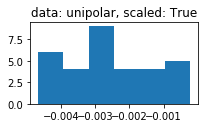

progressive accuracy=========>


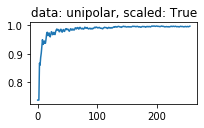

In [11]:
linear_intermittent_perfect_test(rng="Sobol", in_feature=32, out_feature=32, bitwidth=8, bias=True, power_off=128)

--- 0.06405782699584961 seconds ---
input error:  min: -0.0078125 max: 0.0
output error:  min: -0.007620140910148621 max: -0.0036745965480804443 RMSE:  0.005887096747756004
error distribution=========>


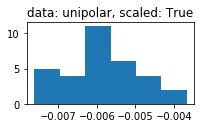

progressive accuracy=========>


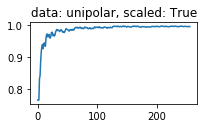

In [14]:
linear_intermittent_perfect_test(rng="Sobol", in_feature=32, out_feature=32, bitwidth=8, bias=True, power_off=250)

--- 0.0640568733215332 seconds ---
input error:  min: -0.0078125 max: 0.00390625
output error:  min: -0.006639882922172546 max: -0.002653181552886963 RMSE:  0.004616720136255026
error distribution=========>


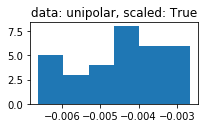

progressive accuracy=========>


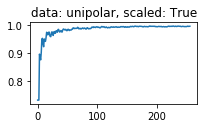

In [13]:
linear_intermittent_perfect_test(rng="Sobol", in_feature=32, out_feature=32, bitwidth=8, bias=True, power_off=28)

--- 0.06405782699584961 seconds ---
input error:  min: -0.0078125 max: 0.00390625
output error:  min: -0.006376773118972778 max: -0.0027849674224853516 RMSE:  0.00455394946038723
error distribution=========>


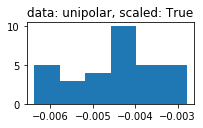

progressive accuracy=========>


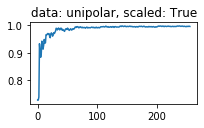

In [15]:
linear_intermittent_perfect_test(rng="Sobol", in_feature=32, out_feature=32, bitwidth=8, bias=True, power_off=75)